## Algoritimo de variação de frequencia de bomba hidraulica

-------------------------------

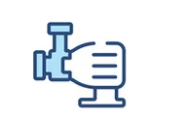

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import numpy.polynomial.polynomial as poly

In [31]:
#fatiar cada parte e colocar no python

### Dados do sistema elétrico

In [32]:
#Rotações por minuto da bomba
n_nominal = 1750
#Frequência da rede em Hz
f_rede_hz = 60
#Tensão da rede em V
V_volt= 380
#Fator de serviço do fabricante para bombas acimda de 20cv   
fator_servico = 1.15
#cos(fi)
fator_potencia = 0.95
#Rendimento do motor. O rendimento é muito próximo de 90% para todos os valores de potência de 60% - 130% do valor nominal. 
#Todas os valores de potência analisados estão nessa faixa. 
eta_motor=0.90
#Potência nominal da bomba
potencial_nominal_cv = 40
#Preço kWh em reais - Suposição feita com base no custo médio da CEMIG
preco_kwh=0.70
#Tempo de funcionamento
tempo_h=240

#O intervalo da vazão de 0 - 60 l/s , porém apenas de 5 l/s a 35 l/s é
#sensato avaliar, pois a bomba tem uma perfomance péssima próxima ou abaixo
#5 l/s e ela simplesmente não consegue prover mais que 35 l/s

x=np.arange(1,60.01,0.01)

### Dados hidraulicos coletados no local

In [33]:
#Viscosidade cinemática da água a 24ºC [m^2/s], página 629 MacYntire
eta=0.000000917
#Diâmetro da tubulação em metros [m]
D_tub=0.20
#Área da seção da tubulação
area= np.pi *(D_tub/2)**2

In [34]:
K_var = 200 # O intervalo adequado é 12 - Até 8000 

#Dados coletados inloco
# a sãos os valores da corrente medido no local [A]
a=np.array([32, 35.5, 41, 43, 46])
# p são os valores de pressão medidos no local [mca]
p=np.array([54.5, 54, 51.5, 49, 46])
# q são os valores de pressão medidos no local [m³/h]
q=np.array([5, 12, 21, 25.5, 32.5])

In [35]:
#Construir o dataframe
data = {'Corrente':a, 'Pressão':p , 'Vazão':q}
dados_coletados = pd.DataFrame.from_dict(data)
dados_coletados

,Corrente,Pressão,Vazão
0,32.0,54.5,5.0
1,35.5,54.0,12.0
2,41.0,51.5,21.0
3,43.0,49.0,25.5
4,46.0,46.0,32.5


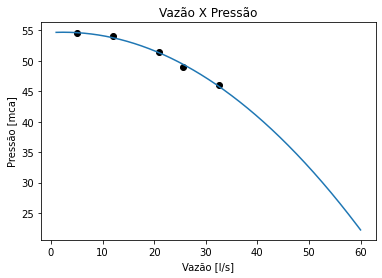

In [45]:
coefs = poly.polyfit(q, p, 2)
bomba = poly.polyval(x, coefs)

plt.plot(x, bomba)
plt.scatter(q,p,c='Black')
plt.xlabel("Vazão [l/s]")
plt.ylabel("Pressão [mca]")
plt.title('Vazão X Pressão')
plt.show()

### Eficiência da bomba

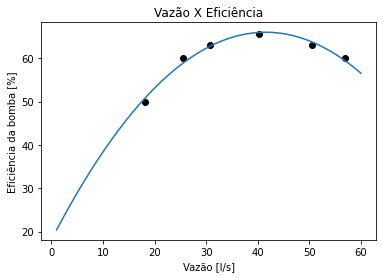

In [44]:
#Dados eficiência da bomba, Fonte: Thebes

eff_y=np.array([50,60,63,65.5,63,60])
eff_x=np.array([65,92,111,145,182,205])

coefs = poly.polyfit(eff_x/3.6, eff_y, 2)
ffit = poly.polyval(x, coefs)

plt.plot(x, ffit)
plt.scatter(eff_x/3.6,eff_y,c='Black')
plt.xlabel("Vazão [l/s]")
plt.ylabel("Eficiência da bomba [%]")
plt.title('Vazão X Eficiência')
plt.show()

In [38]:
#CALCULO NUMERO DE REYNOLDS

#converter a vazão de l/s para m³/s
q_m=x/1000
#velocidade média da água em m/s
velocidade=q_m/area

Reynolds=(D_tub*velocidade)/eta

np.min(Reynolds)

6942.418455480713

In [39]:
#PERDA DE CARGA PRIMÁRIA
#Rugosidade relativa da tubulação
epsilon= 0.005334
#Rugosidade absoluta, fibra de vidro [mm]
rugosidade_relativa=epsilon/(D_tub*1000)
#Equação de Darcy-Weisbach 
#Aceleração da gravidade [m/s²]
g = 9.81 
#Comprimento total da tubulação [m]
L = 218 

#f_D = ((1./(-1.8.*log10(((rugosidade_relativa./3.7).^1.11)+(6.9./Reynolds)))).^2);
f_D = ((1/(-1.8*np.log10(((rugosidade_relativa/3.7)**1.11)+(6.9/Reynolds))))**2)
h_f = f_D*((L*(velocidade**2))/(D_tub*2*g))
#Diferença de altura do ponto de coleta à ao reservatório [mca]
h_e = 44;


In [40]:
#PERDA DE CARGA SECUNDÁRIA
#Perda de carga decorrente do uso de acessórios
#MacIntyre pag 656
K_entrada= 0.1
K_saida = 1

#O K da valvula varia conforme o nível de oclusão, diametro da valvula,
#assim como o material. Algumas fontes indicam que esse valor tem de fato
#variação de mais de 600x de totalmente aberto até 7/8 de oclusão.
#Cheguei a valores empiricos na analise desse K_ValvulaRegistro.

#1.4(totalmente aberto) - Até 8000 (Quase total oclusão)
K_ValvulaRegistro = K_var; 
K_Curva45 = 1.5
K_Curva90Longa = 4.3;
K_Curva90Media = 5.5;
K_Curva90Curta = 6.4;

K= K_saida + K_entrada + K_ValvulaRegistro + K_Curva45 + K_Curva90Longa + K_Curva90Media + K_Curva90Curta
K_nominal = K_saida + K_entrada + K_Curva45 + K_Curva90Longa + K_Curva90Media + K_Curva90Curta + 1.4

h_a = (K)*((velocidade**2)/(2*g));
h_a_nominal = (K_nominal)*((velocidade**2)/(2*g));

#Perda de carga total da tubulação
h_total = h_e + h_f + h_a
h_total_nominal = h_e + h_f + h_a_nominal

In [41]:
eqn= np.abs(bomba - h_total)

valor_minimo = np.min(eqn)
indice_minimo = np.where(eqn == valor_minimo)
Z = indice_minimo[0][0]

rot_nova =  round((np.sqrt(h_total_nominal[Z]/bomba[Z]))*n_nominal)
print(f'A rotação nova é {rot_nova}')

#MUDANÇA DE FREQUENCIA - MCINTYRE p.125
#Algo entre 1570 - 1750
bomba_rotnova = bomba*((rot_nova/n_nominal)**2);

A rotação nova é 1653


### Gráficos


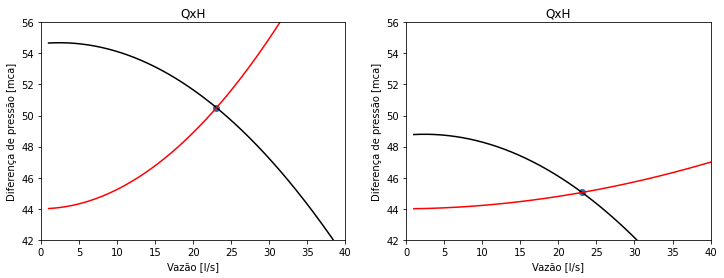

In [42]:
plt.figure(figsize=(12, 4))

#G1
#Gráfico curva da bomba e curva do sistema
plt.subplot(1, 2, 1)

plt.plot(x,bomba,c='Black')
plt.plot(x,h_total,c='Red')
plt.scatter(x[Z],bomba[Z])

plt.xlabel('Vazão [l/s]')
plt.ylabel('Diferença de pressão [mca]')
plt.xlim(0, 40);
plt.ylim(42, 56);
#plt.legend('Curva da bomba nominal','Curva do sistema K_var','Location','northeast')
plt.title('QxH')

#G2
#Gráfico da nova curva
plt.subplot(1, 2, 2)

plt.plot(x,bomba_rotnova, c='Black')
plt.plot(x,h_total_nominal, c='Red')
plt.scatter(x[Z],bomba_rotnova[Z])

plt.xlabel('Vazão [l/s]')
plt.ylabel('Diferença de pressão [mca]')
plt.xlim(0, 40);
plt.ylim(42, 56);
plt.title('QxH')
plt.show()

In [43]:
#POTÊNCIA ELÉTRICA NECESSÁRIA AO SISTEMA
P_kw =((bomba*(3.6*x))/(367*eta_motor*(f_eff_ls/100))/fator_potencia);

#Medido
#A divisão por 1000 é para o valor final já ser em kW.
P_medida_a=((V_volt/1000)*1.73*eta_motor*A)

coefs = poly.polyfit(q, P_medida_a, 2)
P_medida = poly.polyval(x, coefs)

P_kw_rotacao_nova=(bomba_rotnova*(3.6*x))/(367*eta_motor*(f_eff_ls/100));

NameError: name 'f_eff_ls' is not defined

-------------------------------------------------
### Para implementar
---------------------------------------

In [ ]:
'''
#Adptar para os gráficos finais
# Generate curve data
t = np.linspace(-1, 1, 100)
x = t + t ** 2
y = t - t ** 2
xm = np.min(x) - 1.5
xM = np.max(x) + 1.5
ym = np.min(y) - 1.5
yM = np.max(y) + 1.5
N = 50
s = np.linspace(-1, 1, N)
xx = s + s ** 2
yy = s - s ** 2


# Create figure
fig = go.Figure(
    data=[go.Scatter(x=x, y=y,
                     mode="lines",
                     line=dict(width=2, color="blue")),
          go.Scatter(x=x, y=y,
                     mode="lines",
                     line=dict(width=2, color="blue"))],
    layout=go.Layout(
        xaxis=dict(range=[xm, xM], autorange=False, zeroline=False),
        yaxis=dict(range=[ym, yM], autorange=False, zeroline=False),
        title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])])]),
    frames=[go.Frame(
        data=[go.Scatter(
            x=[xx[k]],
            y=[yy[k]],
            mode="markers",
            marker=dict(color="red", size=10))])

        for k in range(N)]
)

fig.show()
'''

---------------------------------------

#### Original em Matlab

    % Dados para adaptar o algoritimo para organizar  
    % adequadamente o gráfico de bomba  
    % Bomba TH 80-315, página 51 manual Thebes  

    % cd C:\Users\(nome_do_usuário)\Desktop\Pump\ScriptsMatLab % Load no scrip caso tenha
    % load curva; %carregar os dados da curva num arquivo curva.mat. Dados em colunas, para principalmente, a função FIT
    clf('reset')

    %Tudo é em função do valor de K_var que equivale a K da valvula registro
    %Varia de 12 (totalmente aberto) até aproximadamente 8000 (quase total
    %oclusão) do sistema. Na literatura é visto alterações desse valor de K de
    %em alguns casos de aproximadamente x576 vezes maior na variação de
    %totalmente aberto a 7/8 de oclusão.
    K_var = 200; % - 12 - Até 8000 -

    %Dados coletados inloco
    %A e a sãos os valores da corrente medido no local
    a=[32 35.5 41 43 46];
    A=a';
    %P e p são os valores de pressão medidos no local
    p=[54.5 54 51.5 49 46];
    P=p';
    %Q e q são os valores de pressão medidos no local
    q=[5 12 21 25.5 32.5];
    Q=q';
    %Os valores de corrente, pressão e vazão são relacionados
    %Por exemplo na primeira coleta P=54.5 Q=5 e A=32.35
    %O " ' " indica apenas que por exemplo Q é a matriz inversa de q, pois a
    %função FIT do matlab só recebe vetores do tipo coluna.

    syms x1 x2 x3 x4 positive

    %Dados do sisteme elétrico
    n_nominal = 1750; %Rotações por minuto da bomba
    f_rede_hz = 60; %Frequência da rede em Hz
    V_volt= 380; %Tensão da rede em V
    fator_servico = 1.15; %Fator de serviço do fabricante para bombas acimda de 20cv   
    fator_potencia = 0.95; %cos(fi)
    eta_motor=0.90; %Rendimento do motor. O rendimento é muito próximo de 90% para todos os valores de potência de 60% - 130% do valor nominal. Todas os valores de potência analisados estão nessa faixa. 
    potencial_nominal_cv = 40;
    preco_kwh=0.70;%Preço kWh em reais - Suposição feita com base no custo médio da CEMIG
    tempo_h=240;%Tempo de funcionamente em horas

    ---------------------------

    %EFICIÊNCIA DA BOMBA
    %Dados eficiência da bomba, Fonte: Thebes
    eff_y=[50;60;63;65.5;63;60];
    eff_x=[65;92;111;145;182;205];

    [f_eff,gof_eff]=fit(eff_x,eff_y,'poly2');  
    [f2,gof_bomba]=fit(Q,P,'poly2'); %Curva da bomba feita em polinômio de grau 2
    %GOF (goodness of fit) é um dado que contém os parametros estatisticos como
    %por exmplo o desvio padrão.

    %intervalo da vazão de 0 - 60 l/s , porém apenas de 5 l/s a 35 l/s é
    %sensato avaliar, pois a bomba tem uma perfomance péssima próxima ou abaixo
    %5 l/s e ela simplesmente não consegue prover mais que 35 l/s
    x=[0:0.01:60];
    para = coeffvalues(f2); %parametrização dos coeficientes do polinômio de segundo grau para a curva da bomba
    bomba = para(1)*x.^2 + para(2)*x + para(3);
    curva_bomba_mh = para(1)*(3.6*x).^2  + para(2)*(3.6*x) + para(3);

    para_eff = coeffvalues(f_eff); %parametrização dos coeficientes do polinômio de segundo grau para a curva de eficiência
    f_eff_ls =(para_eff(1)*(3.6*x).^2 + para_eff(2)*(3.6*x) + para_eff(3)); %Função da eficiência da bomba x Q[l/s]
    f_eff_mh =(para_eff(1)*(x).^2 + para_eff(2)*(x) + para_eff(3)); %Função da eficiência da bomba x Q[m^3/h]

    -------------------------------------------------------

    %Calculo N de Reynolds
    D_tub=0.20;%Diâmetro da tubulação em metros [m]
    area=3.1413*(D_tub/2)^2;%Área da seção da tubulação
    q_m=x/1000; %converter a vazão de l/s para m³/s
    velocidade=q_m/area; %velocidade média da água em m/s
    eta=0.000000917; %Viscosidade cinemática da água a 24ºC [m^2/s], página 629 MacYntire
    Reynolds=(D_tub*velocidade)/eta;

    %PERDA DE CARGA PRIMÁRIA
    %Rugosidade relativa da tubulação
    epsilon= 0.005334; %Rugosidade absoluta, fibra de vidro [mm]
    rugosidade_relativa=epsilon/(D_tub*1000);
    %Equação de Darcy-Weisbach 
    g = 9.81; %Aceleração da gravidade [m/s²]
    L = 218; %Comprimento total da tubulação [m]
    f_D = ((1./(-1.8.*log10(((rugosidade_relativa./3.7).^1.11)+(6.9./Reynolds)))).^2);
    h_f = f_D.*((L.*(velocidade.^2))./(D_tub*2*g));
    %Diferença de altura do ponto de coleta à ao reservatório [mca]
    h_e = 44; 

    %PERDA DE CARGA SECUNDÁRIA
    %Perda de carga decorrente do uso de acessórios
    %MacIntyre pag 656
    K_entrada= 0.1;
    K_saida = 1;
    %O K da valvula varia conforme o nível de oclusão, diametro da valvula,
    %assim como o material. Algumas fontes indicam que esse valor tem de fato
    %variação de mais de 600x de totalmente aberto até 7/8 de oclusão.
    %Cheguei a valores impiricos na analise desse K_ValvulaRegistro.
    K_ValvulaRegistro = K_var; % - 1.4(totalmente aberto) - Até 8000 (Quase total oclusão)
    K_Curva45 = 1.5;
    K_Curva90Longa = 4.3;
    K_Curva90Media = 5.5;
    K_Curva90Curta = 6.4;
    K= K_saida + K_entrada + K_ValvulaRegistro + K_Curva45 + K_Curva90Longa + K_Curva90Media + K_Curva90Curta;
    K_nominal = K_saida + K_entrada + K_Curva45 + K_Curva90Longa + K_Curva90Media + K_Curva90Curta + 1.4;

    h_a = (K).*((velocidade.^2)/(2*g));
    h_a_nominal = (K_nominal).*((velocidade.^2)/(2*g));

    %Perda de carga total da tubulação
    h_total = h_e + h_f + h_a;
    h_total_nominal = h_e + h_f +h_a_nominal;

    eqn=bomba - h_total;
    eqn2=eqn.^2;
    [W,Z]=min(eqn2);%W é o valor real, para realmente se ter noção que é um valor minusculo, muito próximo a 0, Z é o indice

    equac = h_total_nominal(Z) == ((para(1)*x(Z)^2 + para(2)*x(Z) + para(3))*((x1/n_nominal)^2));
    rot_nova = solve(equac,x1);
    n_novo = round(rot_nova)

    %POTÊNCIA ELÉTRICA NECESSÁRIA AO SISTEMA
    P_kw =((bomba.*(3.6*x))./(367*eta_motor.*(f_eff_ls./100))./fator_potencia);
    %P_cv =(bomba.*(3.6*x))./(270*eta_motor.*(f_eff_ls./100));

    %Medido
    P_medida_a=((V_volt/1000)*1.73*eta_motor.*A); %A divisão por 1000 é para o valor final já ser em kW.
    [f_ana,gof_ana]=fit(Q,P_medida_a,'poly2');  

    %MUDANÇA DE FREQUENCIA - MCINTYRE p.125
    %n_novo=1600; Algo entre 1570 - 1750
    bomba_rotnova = bomba.*((n_novo/n_nominal)^2);

    P_kw_rotacao_nova=(bomba_rotnova.*(3.6*x))./(367*eta_motor.*(f_eff_ls./100));

    ------------------------------------

    %Gráfico curva da bomba e curva do sistema
    figure(1)
    hold on
    plot(x,bomba,'b')
    plot(x,h_total,'r--')
    plot(x(Z),bomba(Z),'o')
    plot(q, p, 'k.') %plotar os pontos coletados como pontos
    Ponto_de_funcionamento_rot_nominal =[x(Z),bomba(Z)]; % Vazão[l/s] mca[m] 
    xlabel('Vazão [l/s]')
    ylabel('Diferença de pressão [mca]')
    xlim([0 40]);
    ylim([42 58]);
    legend('Curva da bomba nominal','Curva do sistema K_var','Location','northeast')
    title('QxH')
    hold off

    figure(2)
    hold on
    plot(x,bomba_rotnova,'b')
    plot(x,h_total_nominal,'r--')
    plot(x(Z),bomba_rotnova(Z),'o')
    Ponto_de_funcionamento_rot_nominal =[x(Z),bomba(Z)]; % Vazão[l/s] mca[m] 
    xlabel('Vazão [l/s]')
    ylabel('Diferença de pressão [mca]')
    xlim([0 40]);
    ylim([42 58]);
    legend('Curva da bomba nova','Curva do sistema K_const','Location','northeast')
    title('QxH')
    hold off
    %Gráfico eficiência da bomba
    %Segundo MacIntyre pág 126 a eficência da bomba se mantém para baixas
    %mudanças da rotação. Ele considera no seu exemplo um mudança consideravel
    %quando a rotação foi reduzida a 60% da nominal
    figure(3)
    hold on
    plot(x,f_eff_ls)
    plot(x(Z),f_eff_ls(Z),'o')
    xlim([0 40]);
    ylim([20 68]); 
    xlabel('Vazão [l/s]')
    ylabel('Eficiência [%]')
    title('Eficiência da bomba \eta')

    %Gráfico potência consumida em KW
    %29.42 kW = 40 cv = Potência nominal do motor elétrico
    figure(4);
    hold on
    plot(x,P_kw,'r--');
    plot(f_ana,'b');
    plot(x,P_kw_rotacao_nova,'k')
    plot(x(Z),P_kw_rotacao_nova(Z),'o')
    plot(x(Z),P_kw(Z),'o');
    plot(x(Z),f_ana(Z),'o')
    yline(29.42); %Potência nominal do motor elétrico em kW - O equivalente a 40cv, fica uma linha horizontal marcando isso no gráfico
    xlim([0 40]);
    ylim([0 35]); 
    xlabel('Vazão [l/s]')
    ylabel('Potência consumida')
    legend('Potência teórica[kW]','Potência medida[kW]','Location','northwest')
    hold off
    Economia_pot = P_kw(Z) - P_kw_rotacao_nova(Z);
    Economia_financeira = round(tempo_h * preco_kwh * Economia_pot)

    %Gráfico potência consumida em CV
    %figure(4)
    %hold on
    %plot(x,P_cv);
    %yline(40); %Potência nominal do motor elétrico em cv
    %xlim([0 40]);
    %ylim([0 45]); 
    %xlabel('Vazão [l/s]');
    %ylabel('Potência consumida');
    %legend('Potência teórica[cv]','Location','northwest');